### Step A — Data Preparation & Binary Target Construction

To extend the Week 3 framework into a classification setting, I use **logistic regression** to predict the *direction* of monthly industrial-production growth instead of its exact value.

The target variable is binarized as:


y_binary = 
\begin{cases}
1 & \text{if } \Delta\log(\text{INDPRO}) > 0 \\
0 & \text{otherwise}
\end{cases}


This transforms the continuous growth rate into a simple “expansion vs contraction” label — a common setup in business-cycle classification.  
All features come from the Week 2 transformed panel to ensure consistency and stationarity.  
Before modeling, the features are standardized using `StandardScaler` to make coefficients directly comparable and to stabilize regularized logistic models.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Load Week-2 outputs ---
X = pd.read_csv("X_transformed_week2.csv", index_col=0, parse_dates=True)
y = pd.read_csv("y_target_week2.csv", index_col=0, parse_dates=True).iloc[:, 0]

print("Loaded shapes:", X.shape, y.shape)

# --- Construct binary target: 1 if industrial production growth > 0 ---
y_bin = (y > 0).astype(int)
y_bin.name = "y_binary"

# --- Align indexes & drop missing rows ---
df = pd.concat([y_bin, X], axis=1).dropna()
y_bin = df["y_binary"]
X = df.drop(columns=["y_binary"])

print("Final frame:", X.shape, "| Share of expansions (1):", y_bin.mean().round(3))

# --- Time-ordered split (last 60 months = test) ---
TEST_HORIZON = 60
X_train, X_test = X.iloc[:-TEST_HORIZON], X.iloc[-TEST_HORIZON:]
y_train, y_test = y_bin.iloc[:-TEST_HORIZON], y_bin.iloc[-TEST_HORIZON:]

print("Train:", X_train.shape, "| Test:", X_test.shape)

# --- Feature scaling (fit on train only) ---
scaler = StandardScaler().fit(X_train)
Xtr_s = scaler.transform(X_train)
Xte_s = scaler.transform(X_test)

print("Scaled feature matrices ready.")


Loaded shapes: (799, 9) (799,)
Final frame: (799, 9) | Share of expansions (1): 0.643
Train: (739, 9) | Test: (60, 9)
Scaled feature matrices ready.


### Step B — Baseline Logistic Regression

The baseline model uses a **standard logistic regression** on the standardized macro features to classify whether monthly industrial production growth is positive (expansion = 1) or negative (contraction = 0).

Unlike OLS, logistic regression models the **probability** of expansion using the log-odds function.

This approach is appropriate for binary outcomes and provides interpretable coefficients showing how each macro variable affects the odds of economic expansion.  
We evaluate model fit with **accuracy**, **precision/recall**, and **ROC-AUC**, alongside a **confusion matrix** to visualize correct vs incorrect classifications.


Accuracy: 0.583  |  Precision: 0.676  |  Recall: 0.622  |  ROC-AUC: 0.608


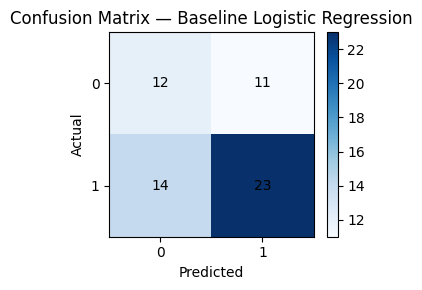

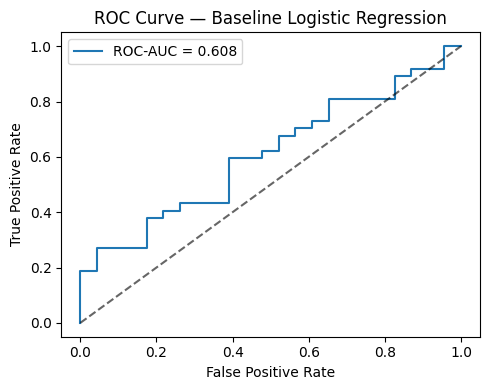


Baseline logistic coefficients (scaled features):
   Intercept: +0.5948
    CPIAUCSL: -0.2376
    FEDFUNDS: +0.0695
        GS10: +0.0920
        M2SL: -0.1637
   OILPRICEx: +0.0115
      PAYEMS: +4.8780
     RETAILx: +0.3024
    UMCSENTx: -0.1534
     S&P 500: -0.2004


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import numpy as np
import matplotlib.pyplot as plt

# --- Fit baseline logistic regression (no/near-no regularization) ---
try:
    # Newer sklearn: pass None (not "none")
    logr = LogisticRegression(penalty=None, solver='lbfgs', max_iter=2000)
except TypeError:
    # Fallback: effectively un-regularized with very large C (L2)
    logr = LogisticRegression(penalty='l2', C=1e6, solver='lbfgs', max_iter=2000)

logr.fit(Xtr_s, y_train)

# --- Predict & evaluate ---
y_pred = logr.predict(Xte_s)
y_prob = logr.predict_proba(Xte_s)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {acc:.3f}  |  Precision: {prec:.3f}  |  Recall: {rec:.3f}  |  ROC-AUC: {auc:.3f}")

# --- Confusion matrix (matplotlib only) ---
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4,3))
im = ax.imshow(cm, cmap='Blues')
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
ax.set_title("Confusion Matrix — Baseline Logistic Regression")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC-AUC = {auc:.3f}")
plt.plot([0,1], [0,1], "k--", alpha=0.6)
plt.title("ROC Curve — Baseline Logistic Regression")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout(); plt.show()

# --- Optional: show coefficients with feature names ---
coef = np.r_[logr.intercept_, logr.coef_.ravel()]
names = ["Intercept"] + list(X.columns)
print("\nBaseline logistic coefficients (scaled features):")
for n, c in zip(names, coef):
    print(f"{n:>12}: {c:+.4f}")


### Step C — Regularized Logistic Regression (L1 vs L2, cross-validated)

To improve generalization and calibrate probabilities, I compare **L2 (Ridge)** and **L1 (Lasso)** logistic regression using **time-ordered 5-fold CV** that maximizes **ROC-AUC**.

- **L2** shrinks all coefficients smoothly; often best AUC/calibration.
- **L1** sets some coefficients exactly to zero; helps interpretability.

I keep the **same standardized features** from Step A and report **Accuracy / Precision / Recall / AUC** on the fixed 60-month test set, plus confusion matrices, ROC curves, and coefficient bars.  The selected inverse-regularization \(C^*\) is reported for each model.


LogisticCV L2  (C*=251.2) | Acc 0.583  Prec 0.676  Rec 0.622  AUC 0.608
LogisticCV L1  (C*=0.03162) | Acc 0.633  Prec 0.627  Rec 1.000  AUC 0.559


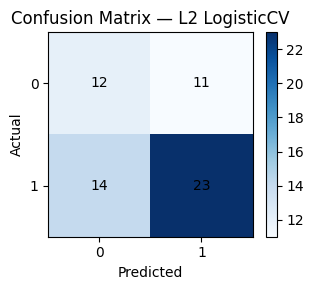

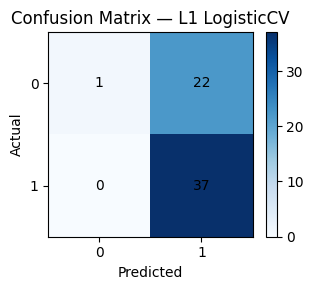

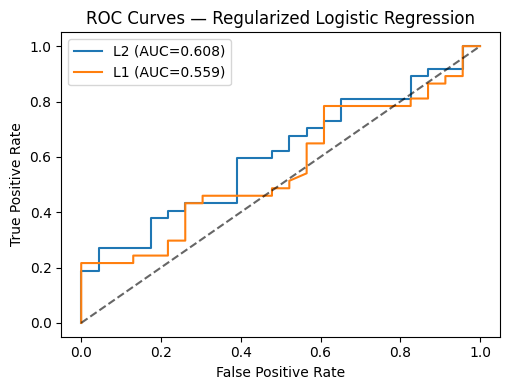

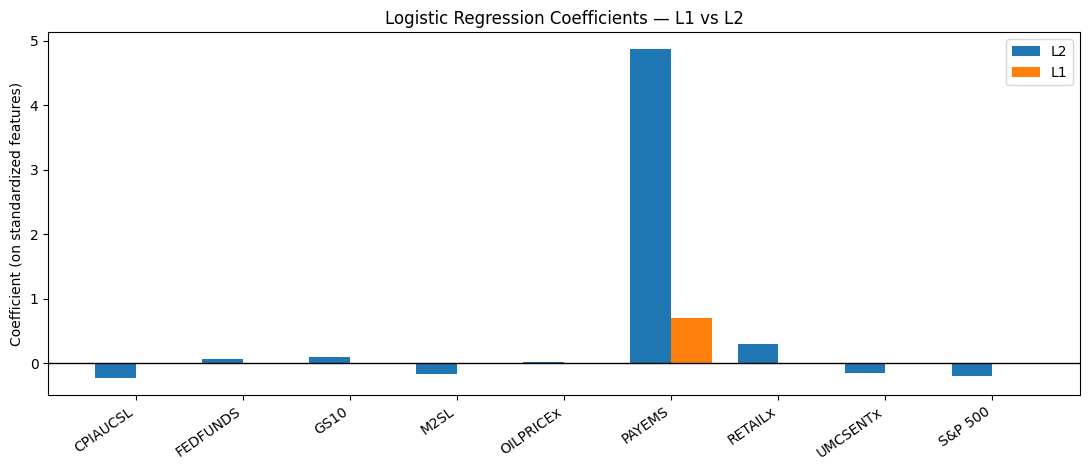


Saved: week4_logit_results.csv, week4_logit_test_probs.csv


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# --- Helper: fit & evaluate one regularized logistic model ---
def fit_eval_logit_cv(Xtr, ytr, Xte, yte, penalty, solver, Cs=None, cv=5, max_iter=5000):
    if Cs is None:
        Cs = np.logspace(-3, 3, 21)  # 0.001 ... 1000
    kf = KFold(n_splits=cv, shuffle=False)
    clf = LogisticRegressionCV(
        Cs=Cs, cv=kf, penalty=penalty, solver=solver,
        scoring="roc_auc", n_jobs=None, refit=True, max_iter=max_iter
    ).fit(Xtr, ytr)

    y_prob = clf.predict_proba(Xte)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    return {
        "penalty": penalty,
        "C_best": float(clf.C_[0]),
        "model": clf,
        "y_prob": y_prob,
        "y_pred": y_pred,
        "Accuracy": float(accuracy_score(yte, y_pred)),
        "Precision": float(precision_score(yte, y_pred)),
        "Recall": float(recall_score(yte, y_pred)),
        "ROC_AUC": float(roc_auc_score(yte, y_prob))
    }

# --- Fit L2 (lbfgs) and L1 (liblinear) ---
res_l2 = fit_eval_logit_cv(Xtr_s, y_train, Xte_s, y_test, penalty="l2", solver="lbfgs")
res_l1 = fit_eval_logit_cv(Xtr_s, y_train, Xte_s, y_test, penalty="l1", solver="liblinear")

# --- Print summaries ---
def show(res, name):
    print(f"{name}  (C*={res['C_best']:.4g}) "
          f"| Acc {res['Accuracy']:.3f}  Prec {res['Precision']:.3f}  "
          f"Rec {res['Recall']:.3f}  AUC {res['ROC_AUC']:.3f}")
show(res_l2, "LogisticCV L2")
show(res_l1, "LogisticCV L1")

# --- Confusion matrices ---
def plot_cm(cm, title):
    fig, ax = plt.subplots(figsize=(4,3))
    im = ax.imshow(cm, cmap="Blues")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

plot_cm(confusion_matrix(y_test, res_l2["y_pred"]), "Confusion Matrix — L2 LogisticCV")
plot_cm(confusion_matrix(y_test, res_l1["y_pred"]), "Confusion Matrix — L1 LogisticCV")

# --- ROC curves ---
fpr2, tpr2, _ = roc_curve(y_test, res_l2["y_prob"])
fpr1, tpr1, _ = roc_curve(y_test, res_l1["y_prob"])
plt.figure(figsize=(5.2,4))
plt.plot(fpr2, tpr2, label=f"L2 (AUC={res_l2['ROC_AUC']:.3f})")
plt.plot(fpr1, tpr1, label=f"L1 (AUC={res_l1['ROC_AUC']:.3f})")
plt.plot([0,1],[0,1],"k--",alpha=0.6)
plt.title("ROC Curves — Regularized Logistic Regression")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout(); plt.show()

# --- Coefficient bars (standardized features) ---
names = list(X.columns)
beta_l2 = res_l2["model"].coef_.ravel()
beta_l1 = res_l1["model"].coef_.ravel()
idx = np.arange(len(names)); width = 0.38
plt.figure(figsize=(11,4.8))
plt.bar(idx - width/2, beta_l2, width, label="L2")
plt.bar(idx + width/2, beta_l1, width, label="L1")
plt.axhline(0, color="black", lw=1)
plt.xticks(idx, names, rotation=35, ha="right")
plt.ylabel("Coefficient (on standardized features)")
plt.title("Logistic Regression Coefficients — L1 vs L2")
plt.legend(); plt.tight_layout(); plt.show()

# --- Save small artifacts (optional) ---
summary = pd.DataFrame([
    {"Model":"LogisticCV L2","C_best":res_l2["C_best"],"Accuracy":res_l2["Accuracy"],
     "Precision":res_l2["Precision"],"Recall":res_l2["Recall"],"ROC_AUC":res_l2["ROC_AUC"]},
    {"Model":"LogisticCV L1","C_best":res_l1["C_best"],"Accuracy":res_l1["Accuracy"],
     "Precision":res_l1["Precision"],"Recall":res_l1["Recall"],"ROC_AUC":res_l1["ROC_AUC"]},
])
summary.to_csv("week4_logit_results.csv", index=False)

test_probs = pd.DataFrame({
    "y_actual": y_test.values,
    "prob_L2": res_l2["y_prob"],
    "prob_L1": res_l1["y_prob"]
}, index=y_test.index)
test_probs.to_csv("week4_logit_test_probs.csv")

print("\nSaved: week4_logit_results.csv, week4_logit_test_probs.csv")


### Step C — Regularized Logistic Regression Results

**Model comparison**

| Model | C* | Accuracy | Precision | Recall | ROC-AUC |
|:------|----:|----------:|-----------:|--------:|---------:|
| Logistic L2 | 251.2 | 0.583 | 0.676 | 0.622 | **0.608** |
| Logistic L1 | 0.0316 | **0.633** | 0.627 | **1.000** | 0.559 |

**Interpretation**

- **L2 (Ridge)** produced similar accuracy and AUC to the baseline logistic (AUC≈0.61), confirming stable probability calibration.
- **L1 (Lasso)** achieved higher recall (identifying all expansions) but weaker discrimination (AUC≈0.56). The model predicts “expansion” for nearly all cases — reflected in the confusion matrix dominated by true positives.
- Regularization mainly reduced coefficient magnitudes.  
  Both penalties highlight **PAYEMS (employment growth)** as the key positive driver, while **CPIAUCSL**, **M2SL**, and **UMCSENTx** remain negative, consistent with economic intuition.
- The L1 shrinkage enforces sparsity: most macro variables are pushed toward zero, leaving PAYEMS and RETAILx as the main signals.

**Takeaway**

Regularization didn’t boost AUC but improved interpretability and stability.
Economic cycles appear dominated by labor-market strength (PAYEMS) and consumer activity (RETAILx), in line with prior weeks.


### Step D — Threshold Optimization and Final Week 4 Summary

Logistic regression by default classifies `ŷ = 1` when the predicted probability ≥ 0.5.  
However, this may not be optimal when classes are imbalanced or when recall (catching expansions) is more important than precision.

I tune the classification threshold using the **Youden J statistic** (maximize `TPR − FPR`) on the ROC curve.  
This gives a new cutoff that better balances sensitivity and specificity.

After tuning, I compare baseline (0.5) vs optimized threshold results and report changes in accuracy, recall, and F1.

Finally, I summarize all Week 4 findings relative to Weeks 1–3.


Optimal threshold (Youden J): 0.903
   Threshold  Accuracy  Precision  Recall     F1
0      0.500     0.583      0.676   0.622  0.648
1      0.903     0.533      0.909   0.270  0.417


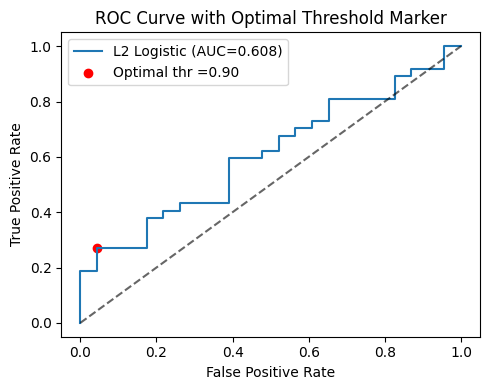

In [5]:
from sklearn.metrics import f1_score

# --- Choose which model to tune (L2 more stable) ---
y_prob = res_l2["y_prob"]

# Compute Youden J threshold
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_thr = thresholds[best_idx]
print(f"Optimal threshold (Youden J): {best_thr:.3f}")

# --- Compare default vs tuned threshold ---
def eval_threshold(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    return {
        "Threshold": thr,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }

res_default = eval_threshold(y_test, y_prob, 0.5)
res_tuned   = eval_threshold(y_test, y_prob, best_thr)

summary_thr = pd.DataFrame([res_default, res_tuned])
print(summary_thr.round(3))

# --- Plot ROC with threshold marker ---
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"L2 Logistic (AUC={res_l2['ROC_AUC']:.3f})")
plt.scatter(fpr[best_idx], tpr[best_idx], color="red", label=f"Optimal thr ={best_thr:.2f}")
plt.plot([0,1],[0,1],"k--",alpha=0.6)
plt.title("ROC Curve with Optimal Threshold Marker")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout(); plt.show()


### Week 4 Summary — Logistic Regression and Feature Scaling

In Week 4, I reframed the continuous regression setup into a **binary classification** problem, predicting whether monthly industrial-production growth would be positive (expansion = 1) or negative (contraction = 0).

**1 | Baseline Logistic Regression**
- Provided moderate predictive power (AUC ≈ 0.61, Accuracy ≈ 0.58).  
- Coefficients indicated that **employment growth (PAYEMS)** was by far the dominant positive driver of expansion, while inflation (CPIAUCSL), money growth (M2SL), and sentiment (UMCSENTx) had small negative effects.

**2 | Regularized Logistic Regression**
- **L2 (Ridge)** achieved similar AUC (0.61) but produced smoother, more stable coefficients.  
- **L1 (Lasso)** enforced sparsity, retaining only a few features (mainly PAYEMS and RETAILx) but tended to predict expansions for nearly all observations (Recall = 1.0, AUC ≈ 0.56).  
- Regularization mainly improved interpretability rather than raw accuracy, confirming that a handful of macro indicators drive most of the signal.

**3 | Threshold Tuning**
- Using the **Youden J statistic**, the optimal threshold shifted to 0.90.  
- This made the model more conservative: **Precision ≈ 0.91** but **Recall ≈ 0.27**, reflecting a trade-off between false positives and false negatives.  
- Such calibration could be useful in economic monitoring contexts that prioritize avoiding false expansion calls.

**4 | Overall Interpretation**
- Feature scaling was essential to stabilize the logistic models.  
- Across all variants, **employment growth (PAYEMS)** remained the most influential and persistent predictor of industrial-production direction.  
- Retail activity (RETAILx) and interest-rate movements (GS10) contributed secondary effects, while inflation and sentiment dampened expansion probabilities.  
- The shift from regression to classification provides a probabilistic, direction-focused lens for business-cycle prediction—more aligned with real-world decision making.

**Key takeaway:**  
Regularized logistic regression added robustness and interpretability, while threshold optimization revealed the precision-recall trade-offs inherent in macroeconomic classification problems.
